In [1]:
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import make_classification
from tqdm import tqdm
from scipy.stats import norm
import pandas as pd

In [2]:
def fitModel(model,optimizer,criterion,epochs,x,target, a=False):
    for epoch in range(epochs):
            # Forward pass: Compute predicted y by passing x to the model
        if a is not None:
            y_pred,_ = model(x)
        else:
            y_pred,_ = model(x,a)
        # Compute and print loss
        loss = criterion(y_pred, target)
        #print(epoch, loss.data[0])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    return model

In [3]:
def softmax(w, t = 1.0):
    e = np.exp(w / t)
    return e/np.sum(e,1)[:,np.newaxis]

In [4]:
class Net(nn.Module):
    def __init__(self,d,q):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d, q),
        )

    def forward(self,x):
        #x = torch.tanh(self.fc(x))
        x = self.fc(x)
        x1 = F.softmax(x, dim=1)
        return x1,x

In [5]:
class TRAM(nn.Module):
    def __init__(self, d, d1, d2, q):
        super(TRAM, self).__init__()
        self.fc_x = nn.Linear(d1, d)
        self.fc_a = nn.Linear(d2, d)
        # No PI head
        self.head1 = nn.Sequential(
            nn.Linear(d, q),
            nn.Softmax(dim=1)
        )
        # PI head
        self.head2 = nn.Sequential(
            nn.Linear(d, q)
        )

    def forward(self, x, a=None):
        x = self.fc_x(x)
        # stop gradient for no PI head using .detach()
        y_pred1 = self.head1(x.detach())

        if a is not None:
            a = self.fc_a(a)
            y_pred2 = self.head2(a)
            return y_pred1, y_pred2

        return y_pred1, None

In [6]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [7]:
def do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te):
    t = 1
    l = 1
    l_r=0.01
    epochs=80
    criterion = torch.nn.CrossEntropyLoss()

    """
    Training of privileged model
    """
    xs_tr = Variable(torch.from_numpy(xs_tr)).type(torch.FloatTensor)
    y_tr = Variable(torch.from_numpy(y_tr*1.0)).type(torch.FloatTensor)
    mlp_priv = Net(xs_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_priv.parameters(),lr=l_r)
    mlp_priv=fitModel(mlp_priv,optimizer,criterion,epochs,xs_tr,y_tr)
    xs_te = Variable(torch.from_numpy(xs_te)).type(torch.FloatTensor)
    _,soften=mlp_priv(xs_tr)
    output,_=mlp_priv(xs_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_priv=np.mean(pred==np.argmax(y_te,1))
    """
    Training of regular MLP
    """
    x_tr = Variable(torch.from_numpy(x_tr)).type(torch.FloatTensor)
    mlp_reg = Net(x_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_reg.parameters(),lr=l_r)
    mlp_reg=fitModel(mlp_reg,optimizer,criterion,epochs,x_tr,y_tr)
    x_te = Variable(torch.from_numpy(x_te)).type(torch.FloatTensor)
    output,_=mlp_reg(x_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_reg=np.mean(pred==np.argmax(y_te,1))

    softened=soften.detach()
    softened=softened.numpy()
    p_tr=softmax(softened,t)
    p_tr=Variable(torch.from_numpy(p_tr)).type(torch.FloatTensor)

    ### freezing layers
    for param in mlp_priv.parameters():
        param.requires_grad =False
    """
    LUPI Combination of two model
    """
    mlp_dist = Net(x_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_dist.parameters(),lr=l_r)
    # Training loop
    for epoch in range(epochs):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred,_ = mlp_dist(x_tr)
        # Compute and print loss
        loss1 = (1-l)*criterion(y_pred, y_tr)
        loss2 = t*t*l*criterion(y_pred, p_tr)
        loss = loss1 + loss2
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    output,_=mlp_dist(x_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_dis=np.mean(pred==np.argmax(y_te,1))
    """
    Training TRAM.
    """
    mlp_tram = TRAM(x_tr.shape[1], x_tr.shape[1], xs_tr.shape[1], y_tr.shape[1])
    optimizer = optim.Adam(mlp_tram.parameters(),lr=l_r)
    mlp_tram=fitModel(mlp_tram,optimizer,criterion,epochs,x_tr,y_tr,xs_tr)
    output,_=mlp_tram(x_te)
    pred = torch.argmax(output,dim=1)
    pred=pred.numpy()
    res_tram=np.mean(pred==np.argmax(y_te,1))

    return np.array([res_priv, res_reg, res_dis, res_tram])

In [8]:
from scipy.stats import ttest_ind, ttest_rel
# experiment hyper-parameters
n_reps = 30

num_samples = [100, 200, 500, 1000, 2000, 5000, 10000]#, 20000, 50000, 100000]
strengths = range(4, 11)
heatmap_data = {
    "Privileged": np.zeros((len(num_samples), len(strengths) + 2)),
    "Generalized Distillation": np.zeros((len(num_samples), len(strengths) + 2)),
    "No PI": np.zeros((len(num_samples), len(strengths) + 2)),
    "TRAM": np.zeros((len(num_samples), len(strengths) + 2))
               }

heatmap_pval = {
    "Privileged": np.zeros((len(num_samples), len(strengths) + 2)),
    "Generalized Distillation": np.zeros((len(num_samples), len(strengths) + 2)),
    "No PI": np.zeros((len(num_samples), len(strengths) + 2)),
    "TRAM": np.zeros((len(num_samples), len(strengths) + 2))
               }

for i, n_tr in enumerate(num_samples):
    print(f"{n_tr}\t\t")
    R = np.zeros((n_reps, len(strengths) + 2, 4))
    for rep in tqdm(range(n_reps)):
        np.random.seed(rep)
        xx, y = make_classification(n_samples=n_tr+5000, 
                                n_features=21, n_informative=11, n_redundant=0, n_repeated=0, 
                                n_classes=2, flip_y=0.0, class_sep=2., shuffle=False
        )
        y = pd.get_dummies(y).values.astype(np.float32)
        xx, y = unison_shuffled_copies(xx, y)
        for j, strength in enumerate(strengths):   
            xs_tr, x_tr, y_tr = xx[:n_tr, :strength], xx[:n_tr, 5:15], y[:n_tr]
            xs_te, x_te, y_te = xx[n_tr:, :strength], xx[n_tr:, 5:15], y[n_tr:]
            R[rep, j, :] += do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te)

        x_tr, y_tr = xx[:n_tr, 5:15], y[:n_tr]
        x_te, y_te = xx[n_tr:, 5:15], y[n_tr:]
        xs_tr, xs_te = np.hstack((xx[:n_tr, :strength], y_tr)), np.hstack((xx[n_tr:, :strength], y_te))
        R[rep, j+1, :] += do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te)

        xs_tr, xs_te = y_tr, y_te
        R[rep, j+2, :] += do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te)
    means = R.mean(axis=0).round(6)
    stds  = R.std(axis=0).round(6)

    heatmap_data["Privileged"][i, :] = means[:, 0]
    heatmap_data["No PI"][i, :] = means[:, 1]
    heatmap_data["Generalized Distillation"][i, :] = means[:, 2]
    heatmap_data["TRAM"][i, :] = means[:, 3]
    
    for j in range(len(strengths) + 2):
        t_stat_priv, p_value_priv = ttest_rel(R[:,j,1], R[:,j,0])
        t_stat_gd, p_value_gd = ttest_ind(R[:,j,1], R[:,j,2])
        t_stat_tram, p_value_tram = ttest_ind(R[:,j,1], R[:,j,3])
        heatmap_pval["Privileged"][i, j] = p_value_priv
        heatmap_pval["Generalized Distillation"][i, j] = p_value_gd
        heatmap_pval["TRAM"][i, j] = p_value_tram

100		


100%|███████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


200		


100%|███████████████████████████████████████████| 30/30 [00:16<00:00,  1.79it/s]


500		


100%|███████████████████████████████████████████| 30/30 [00:18<00:00,  1.65it/s]


1000		


100%|███████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


2000		


100%|███████████████████████████████████████████| 30/30 [00:23<00:00,  1.28it/s]


5000		


100%|███████████████████████████████████████████| 30/30 [00:40<00:00,  1.34s/it]


10000		


100%|███████████████████████████████████████████| 30/30 [00:55<00:00,  1.85s/it]


In [9]:
heatmap_pval["Generalized Distillation"]

array([[5.31513398e-05, 6.66032105e-04, 1.23127346e-02, 1.06934731e-01,
        3.90091075e-01, 6.87810309e-01, 7.96927817e-01, 9.36899006e-01,
        3.17460557e-01],
       [1.46971705e-04, 3.93413111e-03, 3.35363116e-02, 1.48528743e-01,
        2.42184806e-01, 1.33830972e-01, 9.96540451e-01, 6.51892820e-01,
        7.39359805e-01],
       [5.99266682e-04, 1.31636939e-02, 3.54205408e-02, 1.74735326e-01,
        2.74762527e-01, 3.94030246e-01, 8.29052248e-01, 9.88062242e-01,
        9.18632296e-01],
       [5.98412396e-05, 1.04316166e-02, 5.82248619e-03, 8.13624864e-02,
        2.92063487e-01, 4.30622132e-01, 5.33695579e-01, 6.23046700e-01,
        7.63082361e-01],
       [3.33055548e-04, 1.32119724e-03, 3.22275115e-03, 7.09324942e-02,
        2.39276143e-01, 2.43656437e-01, 7.49021295e-01, 9.76173594e-01,
        8.75558090e-01],
       [1.57309526e-04, 6.85802398e-03, 3.65828086e-02, 1.61197597e-01,
        4.65193949e-01, 4.65258203e-01, 7.85521956e-01, 8.94656422e-01,
        8.5

In [10]:
ns = [100, 200, 500, 1000, 10000, 20000]
strengths = range(10, 12)

for n_tr in ns:
    xx, y = make_classification(n_samples=n_tr+5000, 
                                n_features=20, n_informative=10, n_redundant=0, n_repeated=0, 
                                n_classes=2, flip_y=0.0, class_sep=2., shuffle=False
        )
    y = pd.get_dummies(y).values.astype(np.float32)
    xx, y = unison_shuffled_copies(xx, y)
    for j, strength in enumerate(strengths):  
        print(j)
        xs_tr, x_tr, y_tr = xx[:n_tr, :strength], xx[:n_tr, 5:15], y[:n_tr]
        xs_te, x_te, y_te = xx[n_tr:, :strength], xx[n_tr:, 5:15], y[n_tr:]
        res_priv, res_reg, res_dis, res_tram = do_exp(x_tr,xs_tr,y_tr,x_te,xs_te,y_te)

        #print(f'n_tr: {n_tr}; strength: {strength} -- {res_reg, res_priv}')

    #print(f'n_tr: {n_tr} -- {res_reg}')


0
1
0
1
0
1
0
1
0
1
0
1


In [11]:
heatmap_pval['TRAM'].round(2)

array([[0.12, 0.27, 0.1 , 0.15, 0.23, 0.58, 0.6 , 0.15, 0.06],
       [0.1 , 0.17, 0.17, 0.1 , 0.09, 0.06, 0.17, 0.36, 0.28],
       [0.08, 0.14, 0.05, 0.06, 0.03, 0.05, 0.07, 0.07, 0.08],
       [0.08, 0.03, 0.05, 0.01, 0.19, 0.03, 0.01, 0.08, 0.  ],
       [0.06, 0.01, 0.02, 0.04, 0.05, 0.07, 0.05, 0.06, 0.14],
       [0.05, 0.07, 0.03, 0.06, 0.14, 0.06, 0.03, 0.05, 0.08],
       [0.07, 0.03, 0.04, 0.1 , 0.03, 0.06, 0.02, 0.02, 0.01]])

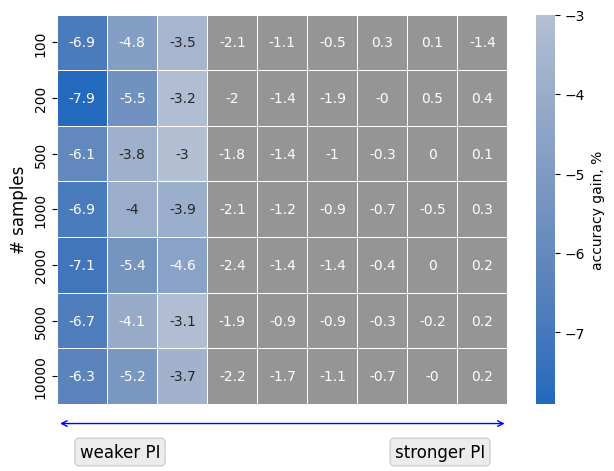

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

dupi_uplift = ((heatmap_data['Generalized Distillation'] - heatmap_data['No PI']) * 100).round(1)
mask = heatmap_pval['Generalized Distillation'] < 0.05
y_axis_labels = num_samples

#sns.heatmap(np.where(dupi_sign, dupi_uplift, -100), annot=True, square=True, cbar=False, 
            #cmap=sns.color_palette("Greys", n_colors=1, desat=1))
sns.heatmap(dupi_uplift, mask=mask, annot=True, cbar=False, 
            cmap=sns.color_palette("Greys", n_colors=1, desat=1))
ax = sns.heatmap(dupi_uplift, mask=~mask, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
                 yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
# ax = sns.heatmap(dupi_uplift, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
#                  yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
ax.annotate('', xy=(0, -0.05), xycoords='axes fraction', xytext=(1, -0.05), 
            arrowprops=dict(arrowstyle="<->", color='b'))
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
ax.text(0.05, -0.1, 'weaker PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, 'stronger PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
plt.ylabel('# samples', fontsize = 12) # x-axis label with fontsize 15
plt.tight_layout()
plt.savefig('pics/dupi_heatmap.png', bbox_inches='tight')
plt.show()

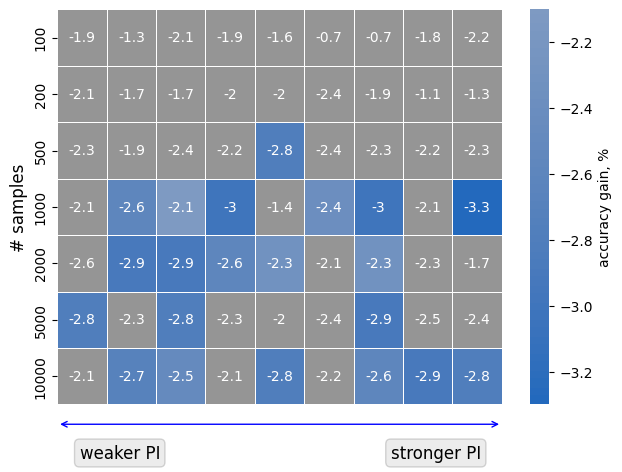

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

tram_uplift = ((heatmap_data['TRAM'] - heatmap_data['No PI']) * 100).round(1)
mask = heatmap_pval['TRAM'] < 0.05
y_axis_labels = num_samples

#sns.heatmap(np.where(dupi_sign, dupi_uplift, -100), annot=True, square=True, cbar=False, 
            #cmap=sns.color_palette("Greys", n_colors=1, desat=1))
sns.heatmap(tram_uplift, mask=mask, annot=True, cbar=False, 
            cmap=sns.color_palette("Greys", n_colors=1, desat=1))
ax = sns.heatmap(tram_uplift, mask=~mask, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
                 yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
# ax = sns.heatmap(tram_uplift, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
#                  yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
ax.annotate('', xy=(0, -0.05), xycoords='axes fraction', xytext=(1, -0.05), 
            arrowprops=dict(arrowstyle="<->", color='b'))
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
ax.text(0.05, -0.1, 'weaker PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, 'stronger PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
plt.ylabel('# samples', fontsize = 12) # x-axis label with fontsize 15
plt.tight_layout()
plt.savefig('pics/tram_heatmap.png', bbox_inches='tight')
plt.show()

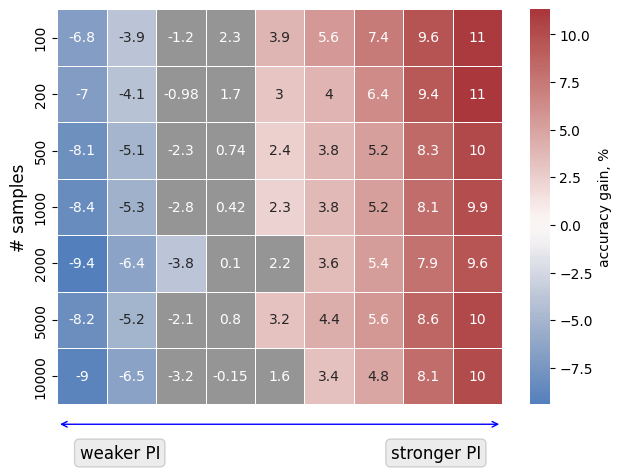

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

pi_uplift = (heatmap_data['Privileged'] - heatmap_data['No PI']) * 100
mask = heatmap_pval['Privileged'] < 0.05
y_axis_labels = num_samples

#sns.heatmap(np.where(dupi_sign, dupi_uplift, -100), annot=True, square=True, cbar=False, 
            #cmap=sns.color_palette("Greys", n_colors=1, desat=1))
sns.heatmap(pi_uplift, mask=mask, annot=True, cbar=False, 
            cmap=sns.color_palette("Greys", n_colors=1, desat=1))
ax = sns.heatmap(pi_uplift, mask=~mask, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
                 yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
# ax = sns.heatmap(pi_uplift, linewidth=0.5, cmap ="vlag", center=0, annot=True, xticklabels=False, 
#                  yticklabels=y_axis_labels, cbar_kws={'label': 'accuracy gain, %'})
ax.annotate('', xy=(0, -0.05), xycoords='axes fraction', xytext=(1, -0.05), 
            arrowprops=dict(arrowstyle="<->", color='b'))
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)  # bbox features
ax.text(0.05, -0.1, 'weaker PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, 'stronger PI', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
plt.ylabel('# samples', fontsize = 12) # x-axis label with fontsize 15
plt.tight_layout()
plt.savefig('pics/pi_heatmap.png', bbox_inches='tight')
plt.show()